# Mtb metabolism

- Author: Miguel Álvarez Herrera <miguel.alvarez@uv.es>
- Date: May 2024

## Contents

- Fetching a model
- Simulating growth with bedaquiline
- Simulating growth with BTZ043
- Simulating growth with isoniazid
- Simulating resistance to isoniazid

## References

- Model iEK1011 has been sourced from its publication, Kavvas et al. (2018) DOI: [10.1186/s12918-018-0557-y](https://doi.org/10.1186/s12918-018-0557-y).
- Antibiotic target genes have been sourced from Rienksma et al. (2019) DOI: [10.3389/fcimb.2019.00144](https://doi.org/10.3389/fcimb.2019.00144).
- Gene correspondence to the H37Rv strain has been done using [Mycobrowser](https://mycobrowser.epfl.ch/).
- Other models can be found here:
    - [BiGG Models](http://bigg.ucsd.edu/).
    - [BioModels](https://www.ebi.ac.uk/biomodels/).

## Fetching a model

First, we download Mtb model iEK1011 from the publication's supplementary materials.

In [1]:
import requests
import zipfile
import io

response = requests.get("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5834885/bin/12918_2018_557_MOESM3_ESM.zip", stream=True)
if response.status_code == 200:
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall("iEK1011")

Then, read the JSON file that contains the model.
The publication provides five different media initializations.
We will use the model initialized with middlebrook 7H10 (m7H10) medium
to simulate the *in vitro* growth conditions of *M. tuberculosis*.

Once the model is read, we can obtain a summary of the objective value
(here, biomass growth, or flux through the biomass reaction),
as well as metabolite uptakes and secretions (system inputs and outputs).

In [2]:
import cobra             # COBRApy is an openCOBRA library
import pandas as pd      # pandas is a data data analysis library

from plotnet import NetPlotter

In [3]:
model = cobra.io.load_json_model("iEK1011/iEK1011_m7H10_media.json")
model.summary()

In [4]:
np = NetPlotter(model)  # initialize plotter for later visualization

## Simulating growth with bedaquiline

[Bedaquiline](https://en.wikipedia.org/wiki/Bedaquiline) is an antibiotic
drug used multi-drug-resistant tuberculosis along with other medications.
It blocks the ATP synthase, thus inhibiting the
capacity of the pathogen to make ATP.
It has been suggested that it targets subunit c, which is encoded
by gene *atpE* ([Rv1305](https://mycobrowser.epfl.ch/genes/Rv1305) in H37Rv).

To simulate growth with this antibiotic, we will simulate the inhibition
on its target gene by performing an *in silico* knock-out. First, we need to
find the gene in the model.
At the same time, we can identify in which reaction(s) the gene product
(subunit c of the ATP synthase) is involved.

In [5]:
model.genes.Rv1305

<Gene Rv1305 at 0x260a1747a60>

Then, we can examine the GPR (gene-protein-reaction) rule of said reaction.

In [6]:
model.reactions.ATPS4r.gene_reaction_rule

'Rv1308 and Rv1304 and Rv1311 and Rv1310 and Rv1305 and Rv1306 and Rv1309 and Rv1307'

Let's visualize the reaction with its reagents and products.

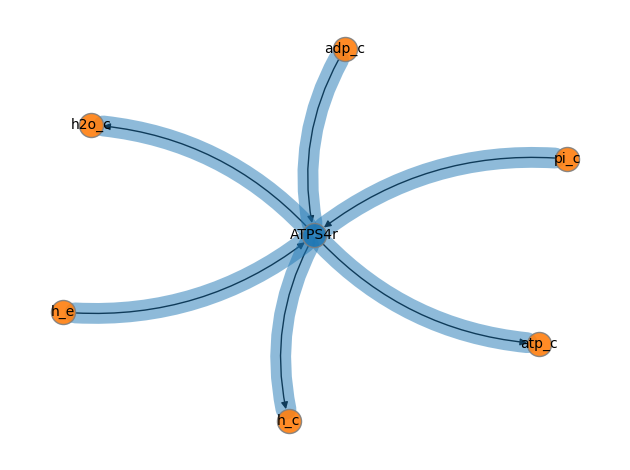

In [7]:
inhA_reactions = set(reaction.id for reaction in model.genes.Rv1305.reactions)
np.plot(reaction_ids=inhA_reactions)

Finally, we can perform flux balance analysis (FBA) to calculate
the baseline growth (a simulation of the bacterium growing in m7H10 medium;
the unaltered, default model settings) and compare it with the growth
with a *atpE* knock-out (a simulation of the bacterium growing in
the same medium plus bedaquiline).

In [8]:
baseline = model.slim_optimize()
print(f"Baseline growth: {baseline:g}")

with model:
    model.genes.Rv1305.knock_out()
    solution = model.optimize()
    reduction_percent = 100 * (baseline - solution.objective_value) / baseline
    print(f"Growth with atpE KO ({solution.status}) = {solution.objective_value:g} ({100 * ((baseline - solution.objective_value) / baseline):g} % decrease)")

Baseline growth: 0.0165647
Growth with atpE KO (infeasible) = 0.43 (-2495.88 % decrease)


c:\Users\Miguel\miniconda3\envs\misb\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


## Simulating growth with BTZ043

1. Find function and target
2. Draw the metabolic network around the target
3. Simulate baseline growth
4. Simulate the administration of BTZ043 by knocking its target out

In [9]:
# answer here!

## Simulating growth with isoniazid

[Isoniazid](https://en.wikipedia.org/wiki/Isoniazid) (INH) is a 
an antibiotic used for the treatment of tuberculosis. Isoniazide itself is not
toxic to the bacterium, but acts as a prodrug is a prodrug that is activated
by the product of gene *katG* ([Rv1908c](https://mycobrowser.epfl.ch/genes/Rv1908c) in H37Rv),
a bacterial catalase-peroxidase enzyme. The activated metabolite inactivates the product
of gene *inhA* ([Rv1484](https://mycobrowser.epfl.ch/genes/Rv1484) in H37Rv), which in turn
inhibits the synthesis of mycolic acids (required components of
the mycobacterial cell wall) and folate.

> More about isoniazid metabolism in Timmins et al. (2006) DOI: [10.1111/j.1365-2958.2006.05467.x](https://doi.org/10.1111/j.1365-2958.2006.05467.x)

First, let's find the genes in the model and assign these genes to variables.
This is purely for convenience! The code will work exactly the same without the substitution.

Then, we can examine and visualize the associated reactions, like we did in the case of bedaquiline.

In [10]:
katG = model.genes.Rv1908c
inhA = model.genes.Rv1484

In [11]:
katG

<Gene Rv1908c at 0x260a1747cd0>

In [12]:
inhA

<Gene Rv1484 at 0x260a1765300>

Here we omit some metabolites that appear in many reactions from the visualization to avoid unnecessary clutter.

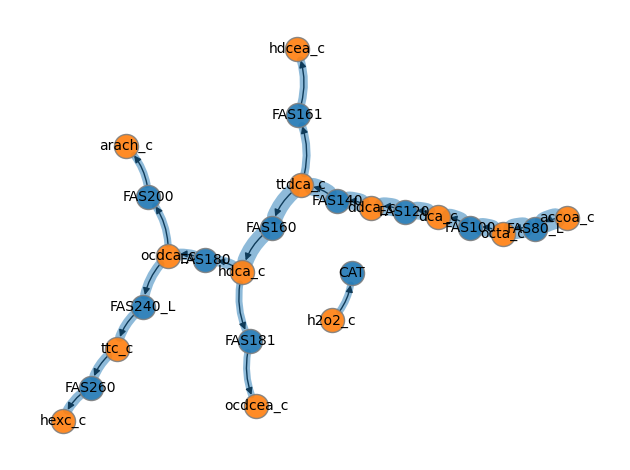

In [13]:
omit = {"h2o_c", "h_c", "nadph_c", "nadp_c", "nadh_c", "nad_c", "co2_c", "o2_c", "coa_c", "malcoa_c"}
reactions = set(reaction.id for reaction in katG.reactions) | set(reaction.id for reaction in inhA.reactions) 
np.plot(reaction_ids=reactions, omit_metabolites=omit)

Then, let's try to identify active reactions within the model (those with non-zero flux as determined
by Flux Balance Analysis), while highlighting the reactions associated with the target gene of
isoniazid, *inhA*. This visualization provides a rough estimate of scale and indicates the
pathway's position within the network.

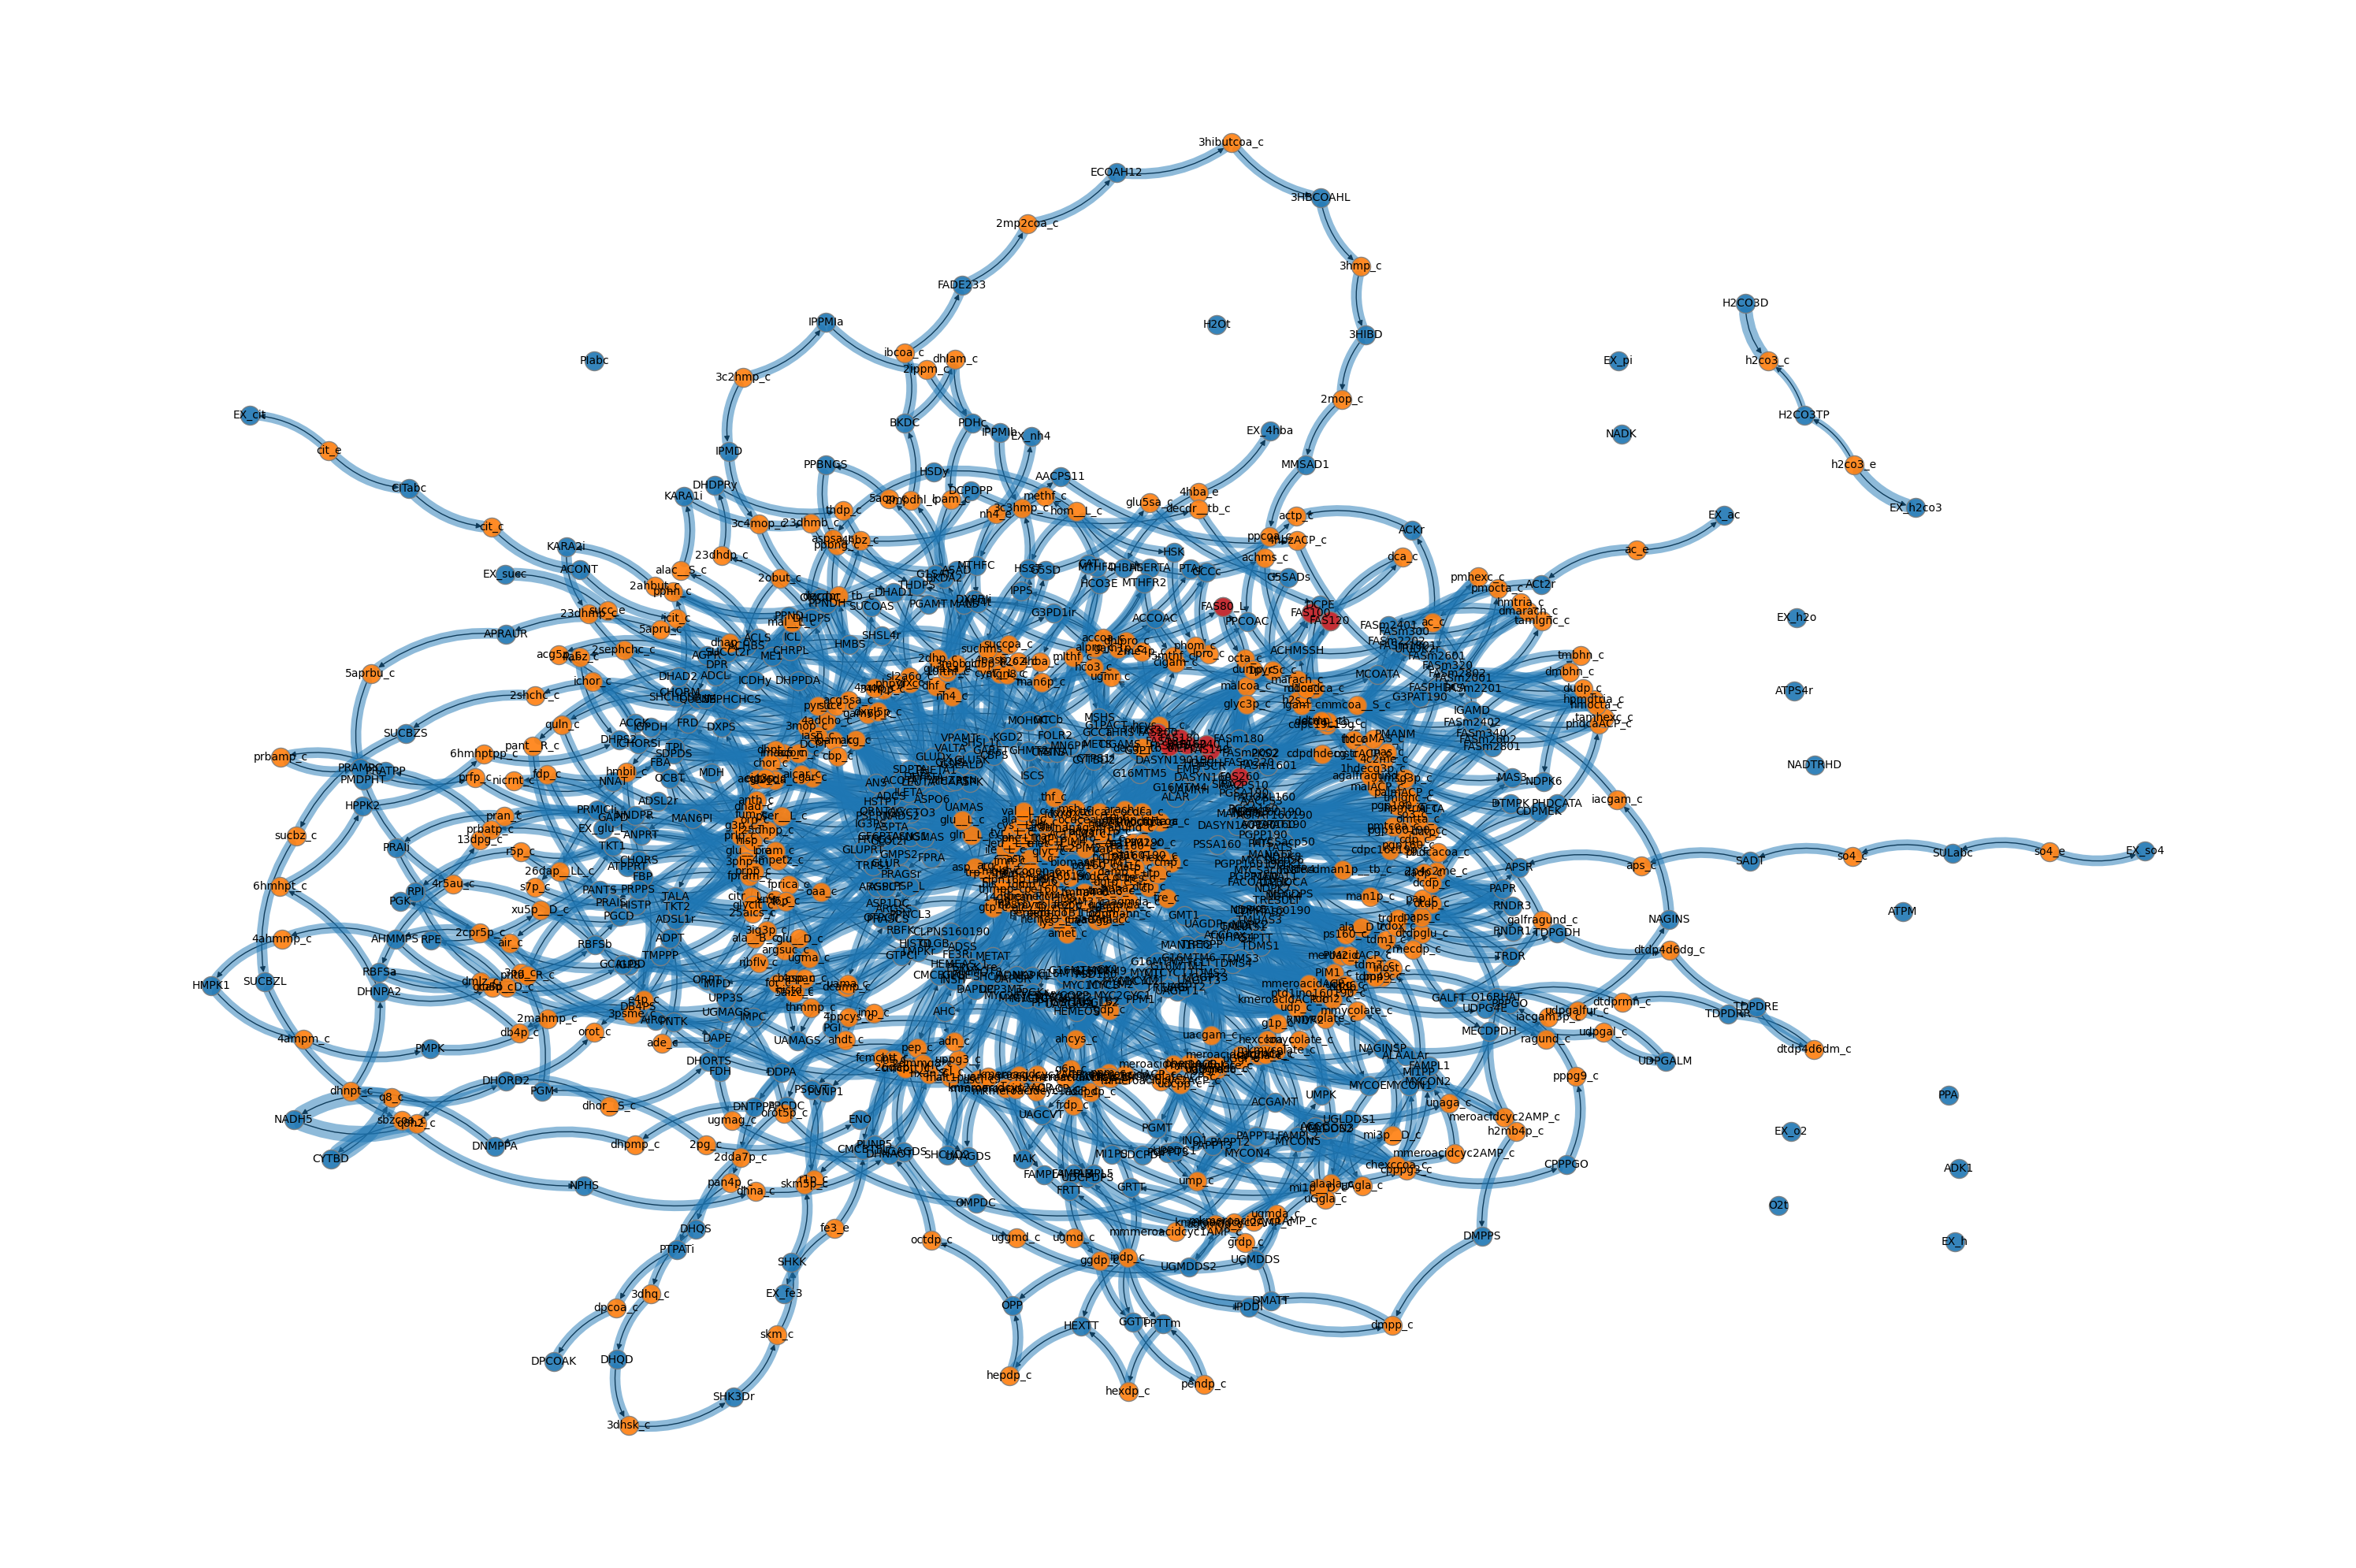

In [14]:
omit = {
    "h2o", "h", "atp", "adp", "amp", "pi",
    "coa", "nad", "co2", "ppi", "nad", "nadh", "nadp",
    "nadph", "fad", "fadh2", "o2", "ACP"
}

solution = model.optimize()
active_reactions = set(solution.fluxes[solution.fluxes.abs() > 1e-9].keys())  # 1e-9 == "zero"
inhA_reactions = set(reaction.id for reaction in inhA.reactions)

np.plot(
    reaction_ids=active_reactions,
    omit_metabolites=set(m + "_c" for m in omit) | set(m + "_e" for m in omit),
    highlight_nodes=inhA_reactions,
    figsize=(30, 20)
)

Finally, let's simulate and quantify the effect on growth
of isoniazid and compare it with the baseline growth, as
we did for bedaquiline.

In [15]:
with model:
    solution = model.optimize()
    print(f"Baseline growth ({solution.status}) = {solution.objective_value:g}")
    baseline = solution.objective_value

Baseline growth (optimal) = 0.0165647


In [16]:
with model:
    inhA.knock_out()
    solution = model.optimize()
    reduction_percent = 100 * (baseline - solution.objective_value) / baseline
    print(f"Growth with inhA KO ({solution.status}) = {solution.objective_value:g} ({reduction_percent:g} % reduction)")

Growth with inhA KO (optimal) = 0 (100 % reduction)


## Simulating resistance to isoniazid

We have simulated the administration of isoniazid by knocking-out
its primary target gene on which it has a growth-inhibiting efect, *inhA*.
We verified the growth inhibition *in silico*.
Now, let's simulate resistance to isoniazid. The simplest way to do this
would be to simulate a loss of function in *katG*.

In [17]:
with model:
    katG.knock_out()
    katG_solution = model.optimize()
    reduction_percent = 100 * (baseline - solution.objective_value) / baseline
    print(f"Growth with katG KO ({solution.status}) = {solution.objective_value:g} ({reduction_percent:g} % reduction)")

Growth with katG KO (optimal) = 0 (100 % reduction)


Although the predicted growth is similar to the baseline, we can
clearly notice that it is not equal, so something must have changed.
What is it? Let's generate a table containing the reactions with a
different optimal flux between the two conditions (baseline and katG KO),
sorted by the absolute value of the difference.

In [18]:
with model:  # this `with` statement is not necessary actually! it's just for consistency
    baseline_solution = model.optimize()

with model:
    katG.knock_out()
    katG_solution = model.optimize()

In [19]:
fluxes = pd.merge(
    baseline_solution.to_frame()["fluxes"], katG_solution.to_frame()["fluxes"],
    left_index=True, right_index=True,
    suffixes=("_baseline", "_katG")
)

fluxes["difference"] = fluxes.fluxes_katG - fluxes.fluxes_baseline
different = fluxes[fluxes.difference.abs() > 0.00001].sort_values("difference", ascending=False, key=lambda x: x.abs())

In [20]:
different

fluxes_baseline  fluxes_katG  difference
METSOXR1         0.000000     0.000477    0.000477
METOX1s          0.000000     0.000477    0.000477
TRDR             0.003137     0.003614    0.000477
CYTBD2           5.258224     5.257823   -0.000402
NADH10           5.258198     5.257796   -0.000402
NADTRHD          4.207754     4.207357   -0.000397
CAT              0.000239     0.000000   -0.000239
ATPS4r           4.167118     4.166913   -0.000205
O2t              2.633244     2.633282    0.000037
EX_o2           -2.633244    -2.633282   -0.000037
FPRA             3.636344     3.636381    0.000037
PTAr            -0.302387    -0.302356    0.000031
ACKr             0.302387     0.302356   -0.000031
ACt2r            0.300071     0.300041   -0.000030
EX_ac           -0.300071    -0.300041    0.000030
SUCOAS          -1.823136    -1.823154   -0.000018
KGD2            -1.824474    -1.824492   -0.000018
MALS             0.167600     0.167583   -0.000017
ICDHy            0.832426     0.832443    0.000017
ICL              0.167574     0.167557   -0.000017
H2CO3TP         -2.839110    -2.839126   -0.000016
H2CO3D           2.839110     2.839126    0.000016
EX_h2co3         2.839110     2.839126    0.000016
EX_h            -4.845535    -4.845551   -0.000016
MDH              0.134182     0.134168   -0.000014
HCO3E            0.122729     0.122716   -0.000012
NH4t            -0.886186    -0.886197   -0.000012
EX_nh4           0.886186     0.886197    0.000012
ACCOAC           0.111443     0.111431   -0.000011
NDPK1            0.111117     0.111106   -0.000011
PEPCK_re         0.107186     0.107175   -0.000011
PGM              0.102479     0.102469   -0.000010
ENO             -0.102479    -0.102469    0.000010

Let's plot them too!

Baseline:


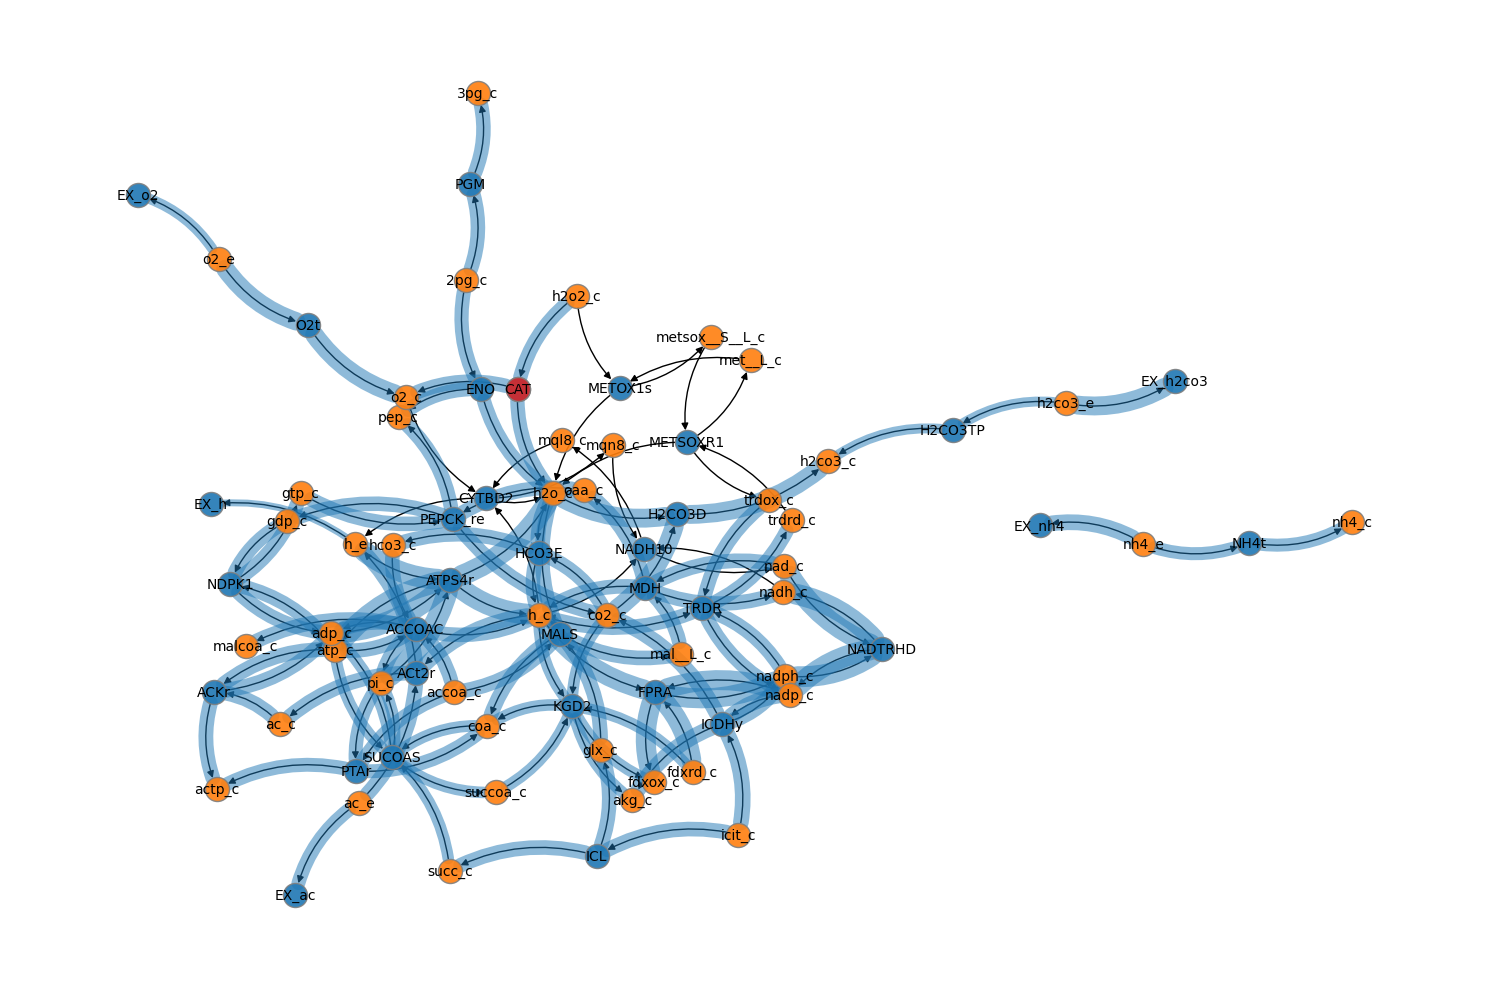

katG KO:


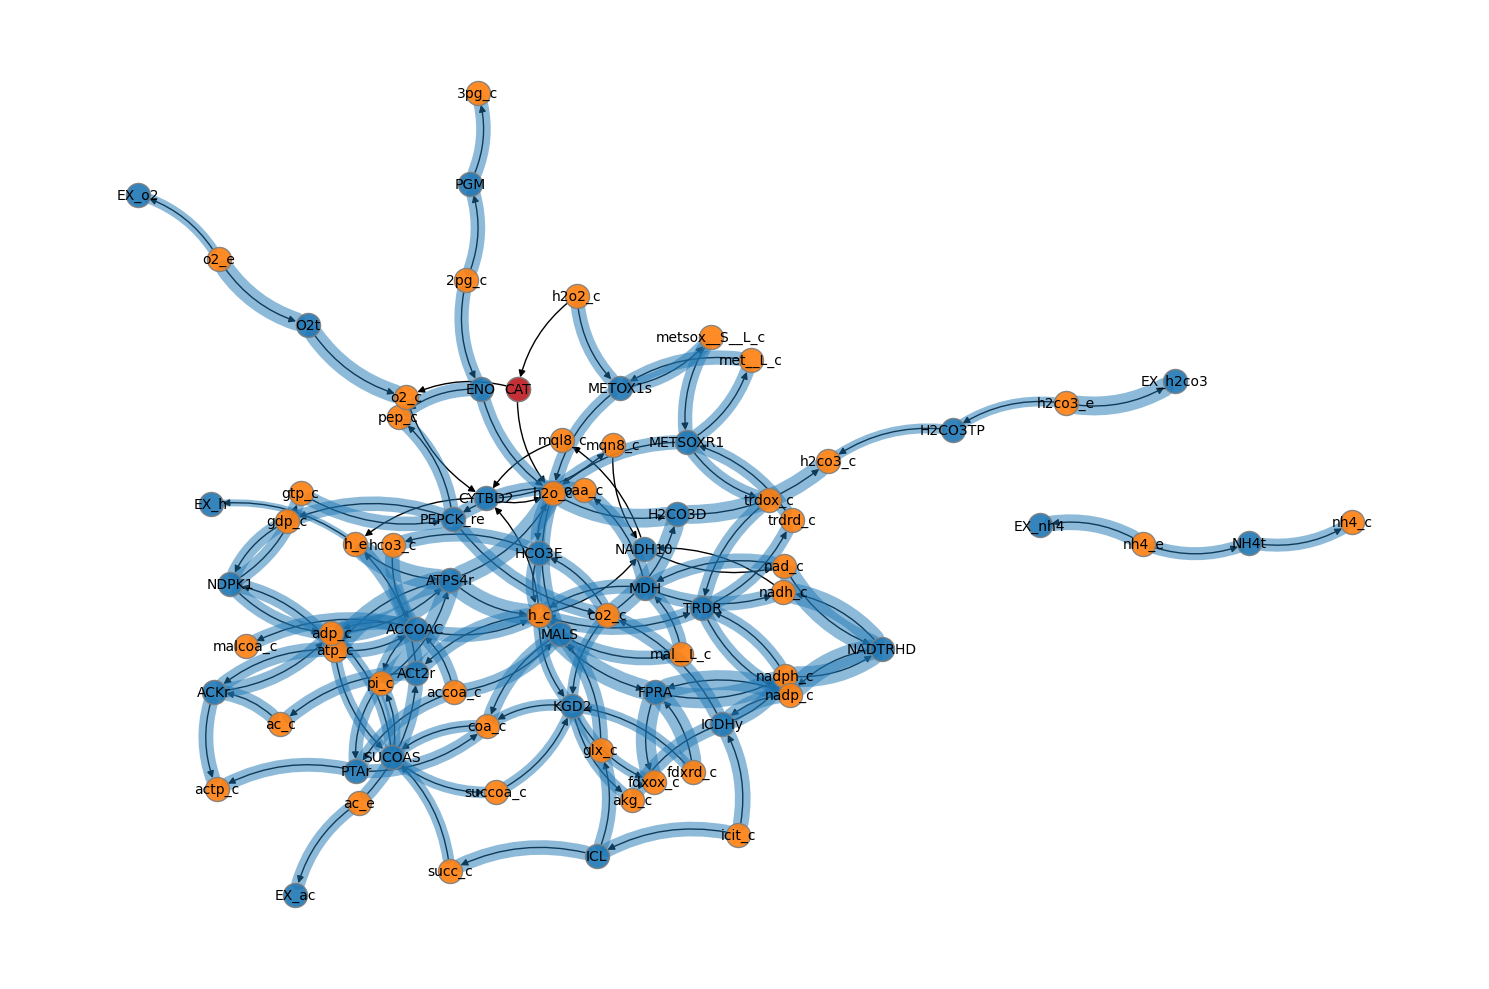

In [21]:
omit = set()

print("Baseline:")
np.plot(
    reaction_ids=set(different.index),
    omit_metabolites=omit,
    highlight_nodes={"CAT"},
    figsize=(15, 10)
)

print("katG KO:")
with model:
    katG.knock_out()
    np.plot(
        reaction_ids=set(different.index),
        omit_metabolites=omit,
        highlight_nodes={"CAT"},
        figsize=(15, 10)
    )

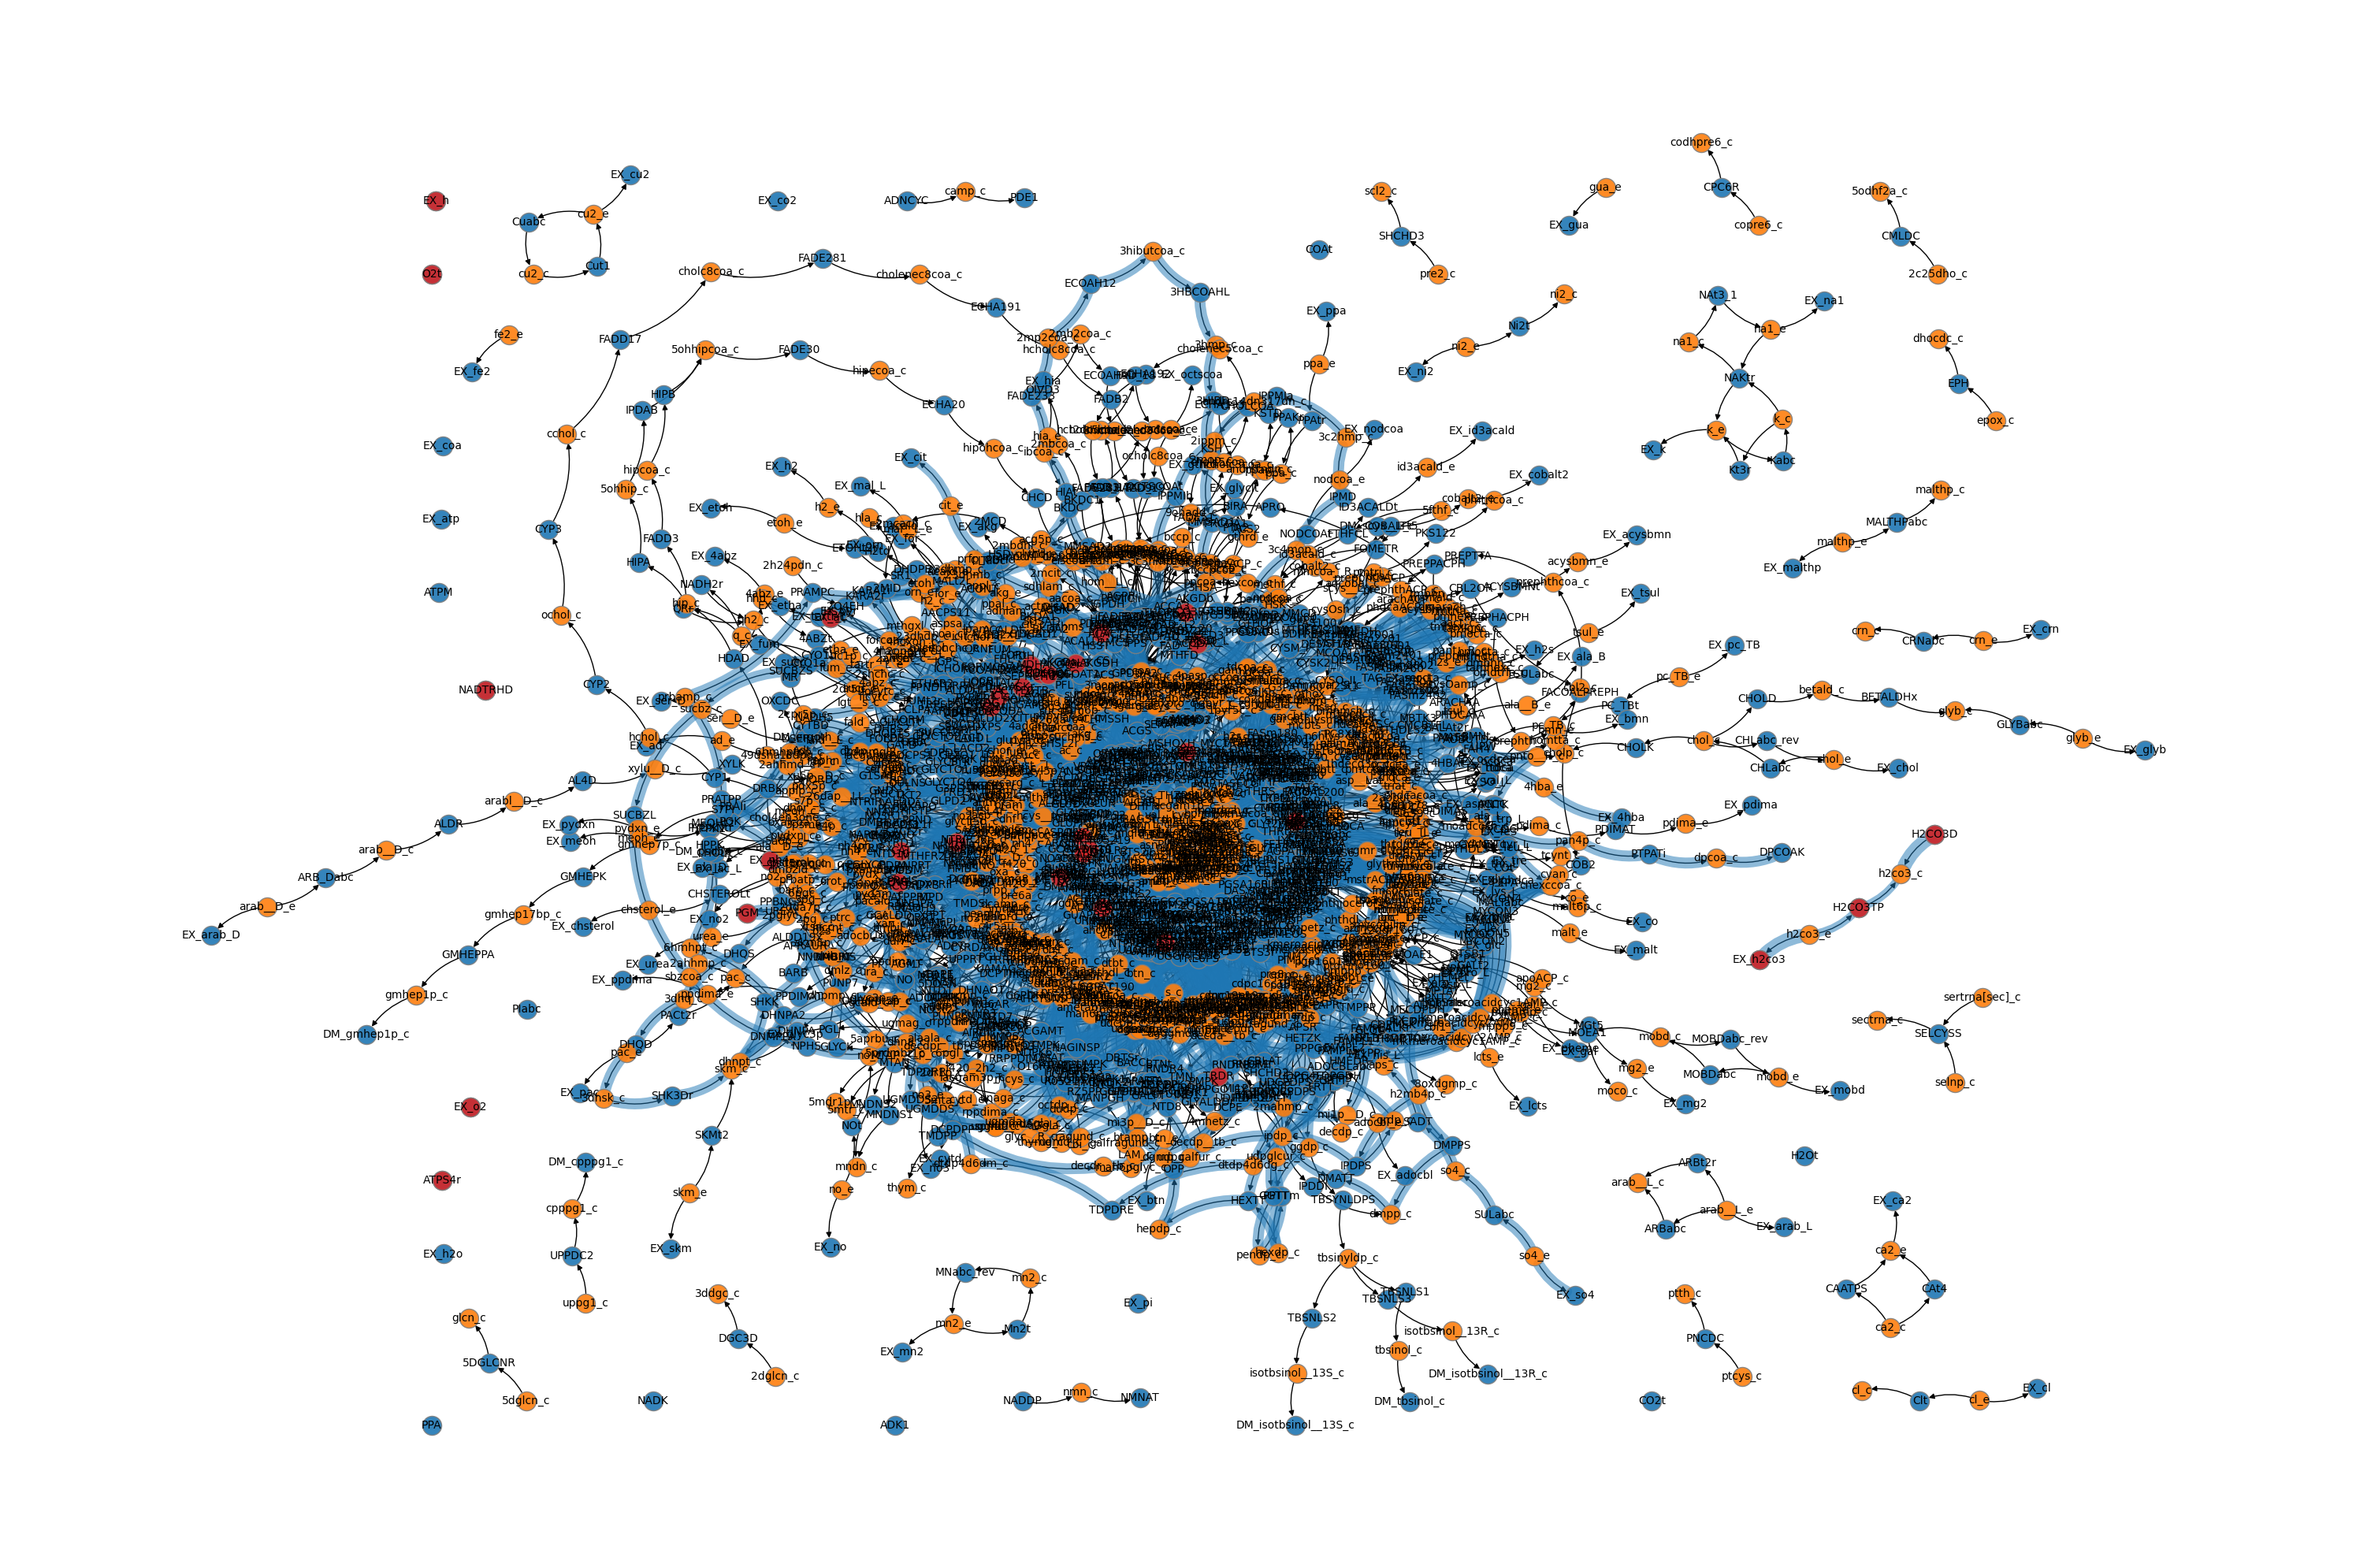

In [22]:
omit = {
    "h2o", "h", "atp", "adp", "amp", "pi",
    "coa", "nad", "co2", "ppi", "nad", "nadh", "nadp",
    "nadph", "fad", "fadh2", "o2", "ACP"
}

active_reactions = set(katG_solution.fluxes[katG_solution.fluxes.abs() > 1e-9].keys())

np.plot(
    reaction_ids=[reaction.id for reaction in model.reactions],
    omit_metabolites=set(m + "_c" for m in omit) | set(m + "_e" for m in omit),
    highlight_nodes=set(different.index),
    figsize=(30, 20)
)